This is a copy, just so that the original contents of `v20p3` are not disturbed.

This uses the results of running `RL_discrete_1q_space_v20_lambda.py` on lambda, and obtaining the files `optimal_policy_discrete_1q_v20.p` and `V_optimal_discrete_1q_v20.p`.<br>
This is essentially the same as `RL_discrete_1q_lambda_run_v20` except that it uses the environment from `RL_discrete_1q_space v20` to actually compute the optimal programs (note the difference in `reset`), even though this was **not** the environment that was used in the actual file `RL_discrete_1q_space_v20_lambda.py`.<br>
This further uses the insights from `RL_discrete_1q_lambda_run_v20p2` to truly find the "optimal" programs.

In [1]:
import gym
import gym.spaces
import numpy as np
from pyquil import get_qc, Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import *
import sys
# from pyquil.api._base_connection import ForestConnection
import pickle

from collections import defaultdict
import sys

In [2]:
# identify discrete gates on qubit 0
num_angles = 1000
angles = np.linspace(0.0, 2 * np.pi, num_angles)
gates = [RY(theta, 0) for theta in angles]
gates += [RZ(theta, 0) for theta in angles]

In [3]:
class OneQEnv(gym.Env):
    
    def __init__(self, goal_angles, bins=(4, 8)):
        # WavefunctionSimulator
        self.wfn_sim = WavefunctionSimulator()
        # Identify discrete state space grid
        self._bins = bins
        self._grid = self.create_uniform_grid(bins=self._bins)
        # Identify desired state
        self.goal_angles = goal_angles
        self.goal_state = self.polar_angles_to_state(self.goal_angles)
        # Create rewards dictionary
        self.d_rewards = defaultdict(lambda: 0)
        self.d_rewards[self.goal_state] = 1
        # Identify discrete state space
        self.state_space = gym.spaces.Discrete((self._bins[0] - 2) * self._bins[1] + 2)
        self.observation_space = self.state_space
        # Identify discrete action space
        self._actions = gates
        self.action_space = gym.spaces.Discrete(len(self._actions))
        # Identify sizes of state and action spaces
        self.nS = self.state_space.n
        self.nA = self.action_space.n
        # Initialize to identity program
        self._program = Program(I(0))
        # Identify state
        self.wfn_to_polar_angles()
        self.state = self.polar_angles_to_state([self._theta, self._phi])
        # consistency checks for polar angles
        assert self._theta >= 0.0 and self._theta <= np.pi
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi
        self.info = {}
        
        
    def reset(self, state=None):
        if state is None:
            state = np.random.choice(self.nS)
        assert state in range(self.nS), "Invalid state"
        angles = self.state_to_polar_angles(state)
        assert state == self.polar_angles_to_state(angles), f"Something went wrong in reset for state {state}"
        # consistency checks
        assert angles[0] >= 0.0 and angles[0] <= np.pi
        assert angles[1] >= 0.0 and angles[1] <= 2 * np.pi

        self.polar_angles_to_prog(angles)
        self.wfn_to_polar_angles()
        self.state = state
        return self.state
    
    
    def step(self, action, shuffle=False):
        
        if shuffle:
            return self.step_shuffle(action)
        
        else:
            return self.step_old(action)
        
        
    def step_old(self, action):
        self._program += self._actions[action]
        self.wfn_to_polar_angles()
        self.state = self.polar_angles_to_state([self._theta, self._phi])
        # consistency checks
        assert self._theta >= 0.0 and self._theta <= np.pi, f"theta: {self._theta} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi, f"phi: {self._phi} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        if self.state == self.goal_state:
            reward = 1
            done = True
        else:
            reward = 0
            done = False

        return self.state, reward, done, self.info


    def step_shuffle(self, action):

        self._program += self._actions[action]

        # first, get polar angles from the new program
        self.wfn_to_polar_angles()

        # identify the resultant state
        self.state = self.polar_angles_to_state([self._theta, self._phi])
        
        # get back the angles from this state
        theta, phi = self.state_to_polar_angles(self.state)
        assert self.state == self.polar_angles_to_state([theta, phi]), f"Something went wrong in step"
        
        # set the angles to these new values
        self._theta = theta
        self._phi = phi

        # convert the perturbed polar angles to new program
        self.polar_angles_to_prog([self._theta, self._phi])

        # convert the perturbed polar angles to new wavefunction
        self.wfn_to_polar_angles()

        # consistency checks
        assert self._theta >= 0.0 and self._theta <= np.pi, f"theta: {self._theta} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi, f"phi: {self._phi} in step; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"

        if self.state == self.goal_state:
            reward = 1
            done = True
        else:
            reward = 0
            done = False

        return self.state, reward, done, self.info


    @classmethod
    def amps_to_polar_angles(self, z):
        # NOTE: This is a poorly named function
        a = z.real
        b = z.imag
        r = np.sqrt(a**2 + b**2)
        angle = np.arctan2(b, a)
        return r, angle
    
    
    @classmethod
    def amps_to_actual_polar_angles(self, z):
        a = z.real
        b = z.imag
        r = np.sqrt(a**2 + b**2)
        angle = np.arctan2(b, a)
        cos_theta_over_2 = np.abs(r[0])
        if cos_theta_over_2 > 1.0: cos_theta_over_2 = 1.0
        theta = 2 * np.arccos(cos_theta_over_2)
        theta = theta % (np.pi)
        phi = angle[1] - angle[0]
        if phi < 0.0: phi += 2 * np.pi
        phi = phi % (2 * np.pi)
        return theta, phi


    def wfn_to_polar_angles(self):
        self._wfn = self.wfn_sim.wavefunction(self._program)
        self._wfn_amps = self._wfn.amplitudes
        self._wfn_polar = self.amps_to_polar_angles(self._wfn_amps)
        cos_theta_over_2 = np.abs(self._wfn_polar[0][0])
        if cos_theta_over_2 > 1.0: cos_theta_over_2 = 1.0
        self._theta = 2 * np.arccos(cos_theta_over_2)
        if self._theta < 0.0: self._theta = -self._theta
        self._phi = self._wfn_polar[1][1] - self._wfn_polar[1][0]
        if self._phi < 0.0: self._phi += 2 * np.pi
        # consistency checks
        assert self._theta >= 0.0 and self._theta <= np.pi, f"theta: {self._theta} in wfn_to_polar_angles; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"
        assert self._phi >= 0.0 and self._phi <= 2 * np.pi, f"phi: {self._phi} in wfn_to_polar_angles; wavefunction: {self._wfn}; wfn_polar: {self._wfn_polar}"


    def create_uniform_grid(self, bins):
        # create grid for angles
        low=[0.0, 0.0]
        high=[np.pi, 2 * np.pi]
        grid_list = []
        for i in range(len(low)):
            tmp_high = high[i]
            tmp_low = low[i]
            tmp_bin = bins[i]
            tmp_diff = (tmp_high - tmp_low) / tmp_bin
            tmp_arr = np.linspace(tmp_low + tmp_diff, tmp_high - tmp_diff, tmp_bin - 1)
            grid_list.append(tmp_arr)
        return grid_list
    
    
    def discretize(self, sample, grid):
        # Discretize a sample as per given grid.
        samps = []
        dims = len(grid)
        for i in range(dims):
            tmp_samp = np.digitize(np.round(sample[i], 2), np.round(grid[i], 2))
            samps.append(tmp_samp)

        samps = np.array(samps)
        assert samps.shape == (dims, )
        return samps


    def state_number(self, discrete_sample, mygrid):
        # expecting an array with 2 entries
        if discrete_sample[0] == 0:
            return 0
        elif discrete_sample[0] == self._bins[0] - 1:
            return (self._bins[0] - 2) * self._bins[1] + 1
        else:
            return (discrete_sample[0] - 1) * self._bins[1] + discrete_sample[1] + 1


    def state_to_polar_angles(self, state_num):
        delta_theta = np.round(self._grid[0][0], 3)
        delta_phi = np.round(self._grid[1][0], 3)
        assert state_num in range(self.nS)
        if state_num == 0:
            theta = 0.0
            phi = 0.0
#             theta = max(0.0 + np.random.uniform(0.0, delta_theta) - 0.01, 0.0)
#             phi = max(0.0 + np.random.uniform(0.0, 2 * np.pi) - 0.01, 0.0)
                    
        elif state_num == (self._bins[0] - 2) * self._bins[1] + 1:
            theta = max(np.pi - delta_theta, np.pi - delta_theta + np.random.uniform(0.0, delta_theta) - 0.01)
            phi = max(0.0 + np.random.uniform(0.0, 2 * np.pi) - 0.01, 0.0)
                    
        else:
            N = self._bins[0]
            M = self._bins[1]
            theta = (np.pi / N) * ((state_num - 1) // M + 1)
            theta = max(theta, theta + np.random.uniform(0.0, delta_theta) - 0.01)
            phi = (2 * np.pi / M) * ((state_num - 1) % M)
            phi = max(phi, phi + np.random.uniform(0.0, delta_phi) - 0.01)

        theta = theta % (np.pi)
        phi = phi % (2 * np.pi)
        # consistency checks
        assert theta >= 0.0 and theta <= np.pi, f"theta: {theta}"
        assert phi >= 0.0 and phi <= 2 * np.pi, f"phi: {phi}"
        return theta, phi
    

    def polar_angles_to_state(self, angles):
        discrete_sample = self.discretize(sample=angles, grid=self._grid)
        state_number = self.state_number(discrete_sample, mygrid=self._grid)
        return state_number
    
    
    def polar_angles_to_prog(self, angles):
        theta = angles[0]
        phi = angles[1]
        self._program = Program(RY(theta, 0), RZ(phi, 0))

In [4]:
env = OneQEnv(goal_angles=np.array([np.pi, 0.0]), bins=(16, 32))
print(f"No. of states: {env.nS}")

No. of states: 450


In [5]:
optimal_policy = pickle.load(open('../optimal_policy_discrete_1q_v20.p', 'rb'))

In [6]:
d_optimal_prog = {}

for s in range(env.nS):
    
    optimal_progs = []
    
    for i in range(100):

        converged = False

        while not converged:

            original_state = env.reset(s)
            original_angles = env.state_to_polar_angles(s)
            original_wfn = env.wfn_sim.wavefunction(env._program)

            state = s
            prog = Program()
            done = False
            counter = 0
            converged = False

            while not done:
                action = np.argmax(optimal_policy[state])
                prog += env._actions[action]
                next_state, reward, done, info = env.step(action)
                state = next_state
                counter += 1
                if counter > 50:
                    break

            if done:
                converged = True
                optimal_progs.append(prog)
    
    # find the min length program
    prog_lengths = [len(p) for p in optimal_progs]
    optimal_progs = [p for p in optimal_progs if len(p) == min(prog_lengths)]
    d_optimal_prog[s] = optimal_progs[0]   # just pick the first of the min length programs
    print(f"original state: {s}")
    print("Optimal Program:\n")
    print(d_optimal_prog[s])
    print("*" * 30)

original state: 0
Optimal Program:

RY(3.138447916198812) 0

******************************
original state: 1
Optimal Program:

RY(2.748500479717196) 0

******************************
original state: 2
Optimal Program:

RY(2.773658378845042) 0

******************************
original state: 3
Optimal Program:

RY(2.779947853627004) 0

******************************
original state: 4
Optimal Program:

RZ(1.9623161319720028) 0
RY(3.3711584831313894) 0

******************************
original state: 5
Optimal Program:

RZ(1.7296055650394255) 0
RY(3.3711584831313894) 0

******************************
original state: 6
Optimal Program:

RZ(1.5660792207084253) 0
RY(3.3711584831313894) 0

******************************
original state: 7
Optimal Program:

RZ(1.3082107546480017) 0
RY(3.3711584831313894) 0

******************************
original state: 8
Optimal Program:

RZ(1.1824212590087708) 0
RY(3.3711584831313894) 0

******************************
original state: 9
Optimal Program:

RZ(0.9

original state: 76
Optimal Program:

RZ(0.7861843477451934) 0
RY(3.7736848691769285) 0

******************************
original state: 77
Optimal Program:

RZ(0.5912106295043854) 0
RY(3.7736848691769285) 0

******************************
original state: 78
Optimal Program:

RZ(0.3836579616996544) 0
RY(3.7736848691769285) 0

******************************
original state: 79
Optimal Program:

RY(3.805132243086736) 0

******************************
original state: 80
Optimal Program:

RY(3.7736848691769285) 0

******************************
original state: 81
Optimal Program:

RY(3.7611059196130054) 0

******************************
original state: 82
Optimal Program:

RY(3.7988427683047745) 0

******************************
original state: 83
Optimal Program:

RZ(2.55981623625835) 0
RY(2.377421467581465) 0

******************************
original state: 84
Optimal Program:

RZ(2.35855304323558) 0
RY(2.377421467581465) 0

******************************
original state: 85
Optimal Program:


original state: 148
Optimal Program:

RZ(2.35855304323558) 0
RY(2.025210879791618) 0

******************************
original state: 149
Optimal Program:

RZ(2.1635793249947723) 0
RY(2.025210879791618) 0

******************************
original state: 150
Optimal Program:

RZ(1.9623161319720028) 0
RY(2.025210879791618) 0

******************************
original state: 151
Optimal Program:

RZ(1.7862108380770794) 0
RY(2.025210879791618) 0

******************************
original state: 152
Optimal Program:

RZ(1.5535002711445023) 0
RY(2.025210879791618) 0

******************************
original state: 153
Optimal Program:

RZ(1.3711055024676173) 0
RY(2.025210879791618) 0

******************************
original state: 154
Optimal Program:

RZ(1.1761317842268093) 0
RY(2.025210879791618) 0

******************************
original state: 155
Optimal Program:

RZ(1.000026490331886) 0
RY(2.025210879791618) 0

******************************
original state: 156
Optimal Program:

RZ(0.83650014

original state: 219
Optimal Program:

RZ(4.119605982184813) 0
RY(4.63534291430566) 0

******************************
original state: 220
Optimal Program:

RZ(3.9246322639440057) 0
RY(4.63534291430566) 0

******************************
original state: 221
Optimal Program:

RZ(3.735948020485159) 0
RY(4.63534291430566) 0

******************************
original state: 222
Optimal Program:

RZ(3.540974302244351) 0
RY(4.63534291430566) 0

******************************
original state: 223
Optimal Program:

RZ(3.3397111092215814) 0
RY(4.63534291430566) 0

******************************
original state: 224
Optimal Program:

RY(1.6163950189641176) 0

******************************
original state: 225
Optimal Program:

RY(1.459158149415079) 0

******************************
original state: 226
Optimal Program:

RZ(2.9246057736121194) 0
RY(4.75484293516293) 0

******************************
original state: 227
Optimal Program:

RZ(2.7422110049352346) 0
RY(4.75484293516293) 0

*******************

original state: 291
Optimal Program:

RZ(2.64157940842385) 0
RY(5.163658795990431) 0

******************************
original state: 292
Optimal Program:

RZ(2.3837109423634266) 0
RY(5.182527220336315) 0

******************************
original state: 293
Optimal Program:

RZ(2.1635793249947723) 0
RY(5.182527220336315) 0

******************************
original state: 294
Optimal Program:

RZ(1.9686056067539643) 0
RY(5.182527220336315) 0

******************************
original state: 295
Optimal Program:

RZ(1.7736318885131563) 0
RY(5.182527220336315) 0

******************************
original state: 296
Optimal Program:

RZ(1.6163950189641176) 0
RY(5.182527220336315) 0

******************************
original state: 297
Optimal Program:

RZ(1.3773949772495788) 0
RY(5.182527220336315) 0

******************************
original state: 298
Optimal Program:

RZ(1.1887107337907326) 0
RY(5.182527220336315) 0

******************************
original state: 299
Optimal Program:

RZ(1.0000264

original state: 362
Optimal Program:

RZ(1.1572633598809248) 0
RY(5.484422009870469) 0

******************************
original state: 363
Optimal Program:

RZ(0.9685791164220783) 0
RY(5.484422009870469) 0

******************************
original state: 364
Optimal Program:

RZ(0.8239211964369627) 0
RY(5.5284483333442) 0

******************************
original state: 365
Optimal Program:

RZ(0.5912106295043854) 0
RY(5.484422009870469) 0

******************************
original state: 366
Optimal Program:

RZ(0.4151053356094621) 0
RY(5.484422009870469) 0

******************************
original state: 367
Optimal Program:

RY(5.6165009802916614) 0

******************************
original state: 368
Optimal Program:

RY(5.484422009870469) 0

******************************
original state: 369
Optimal Program:

RY(5.5284483333442) 0

******************************
original state: 370
Optimal Program:

RY(5.603922030727738) 0

******************************
original state: 371
Optimal Prog

original state: 436
Optimal Program:

RZ(1.9937635058818106) 0
RY(0.2390000417145388) 0

******************************
original state: 437
Optimal Program:

RZ(1.735895039821387) 0
RY(0.2390000417145388) 0

******************************
original state: 438
Optimal Program:

RZ(1.5472107963625406) 0
RY(0.2390000417145388) 0

******************************
original state: 439
Optimal Program:

RZ(1.3836844520315403) 0
RY(0.2390000417145388) 0

******************************
original state: 440
Optimal Program:

RZ(1.1572633598809248) 0
RY(0.2390000417145388) 0

******************************
original state: 441
Optimal Program:

RZ(0.9560001668581553) 0
RY(0.2390000417145388) 0

******************************
original state: 442
Optimal Program:

RZ(0.7421580242714626) 0
RY(0.2390000417145388) 0

******************************
original state: 443
Optimal Program:

RZ(0.5534737808126162) 0
RY(0.2390000417145388) 0

******************************
original state: 444
Optimal Program:

RZ(

In [7]:
set([len(v) for k, v in d_optimal_prog.items()])

{1, 2}

In [ ]:
# wfn_sim = WavefunctionSimulator()

In [ ]:
# # which states have length = 1 for their optimal programs?
# for k, v in d_optimal_prog.items():
#     if len(v) == 1:
#         angles = env.state_to_polar_angles(k)
#         print(f"state: {k}")
#         print(f"original angles: {angles}")
#         prog = Program(RY(angles[0], 0), RZ(angles[1], 0))
#         prog += v
#         wfn = wfn_sim.wavefunction(prog)
#         amps = wfn.amplitudes
#         final_angles = env.amps_to_actual_polar_angles(amps)
#         print(f"final angles: {final_angles}")
#         print(f"final state: {env.polar_angles_to_state(final_angles)}")
#         print("Final wavefunction probabilities")
#         print(wfn.get_outcome_probs())
#         print("\n")

In [ ]:
# env._grid[1][0]

In [ ]:
# np.pi - env._grid[1][0]

In [ ]:
# np.pi - (np.pi / 16)

In [ ]:
# np.pi - (np.pi / 50)

In [ ]:
# So not all of those states converge to the final state 449

# Goal: only keep the programs that *do* converge to the final state 449

In [ ]:
# env.goal_state

In [ ]:
# # Try simply repeating the above code snippet until you find the goal state

# # which states have length = 1 for their optimal programs?
# for k, v in d_optimal_prog.items():

#     if len(v) == 1:
        
#         found_goal = False
        
#         while not found_goal:

#             angles = env.state_to_polar_angles(k)
#             prog = Program(RY(angles[0], 0), RZ(angles[1], 0))
#             prog += v
#             wfn = wfn_sim.wavefunction(prog)
#             amps = wfn.amplitudes
#             outcome_probs = wfn.get_outcome_probs()
#             final_angles = env.amps_to_actual_polar_angles(amps)
#             final_state = env.polar_angles_to_state(final_angles)
#             if final_state == env.goal_state:
#                 found_goal = True

#         print(f"state: {k}")
#         print(f"original angles: {angles}")
#         print(f"final angles: {final_angles}")
#         print(f"final state: {final_state}")
#         print(f"Final wavefunction probabilities: {outcome_probs}")
#         print("\n")

In [ ]:
# So we can simply "reset" repeatedly until we find a starting point for which the optimal program sequence
# leads to the goal state; conclusion: these are truly "optimal" programs for this setup

### Bloch sphere visualization of state-value function

In [8]:
V_optimal = pickle.load(open('../V_optimal_discrete_1q_v20.p', 'rb'))

In [9]:
V_optimal.shape

(450,)

In [12]:
V_geq_4 = [i for i, x in enumerate(V_optimal) if x >= 4.0]
V_less_4 = [i for i, x in enumerate(V_optimal) if x < 4.0]

print(len(V_geq_4))
print(len(V_less_4))

99
351


In [13]:
opt_prog_2 = [k for k, v in d_optimal_prog.items() if len(v) == 2]
opt_prog_1 = [k for k, v in d_optimal_prog.items() if len(v) == 1]

print(len(opt_prog_2))
print(len(opt_prog_1))

351
99


In [16]:
print(set(opt_prog_1) == set(V_geq_4))
print(set(opt_prog_2) == set(V_less_4))

True
True


In [17]:
min_V = min(V_optimal)
max_V = max(V_optimal)

In [18]:
V_optimal_rescaled = (V_optimal - min_V) / (max_V - min_V)
print(min(V_optimal_rescaled))
print(max(V_optimal_rescaled))

0.0
1.0


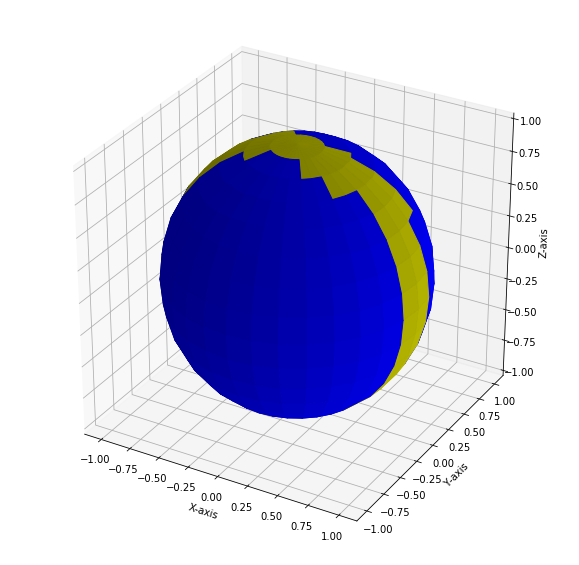

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

r = 1.0

# following the logic of grid creation
bins = (16, 32)
# create grid for angles
low=[0.0, 0.0]
high=[np.pi, 2 * np.pi]
grid_list = []
for i in range(len(low)):
    tmp_high = high[i]
    tmp_low = low[i]
    tmp_bin = bins[i]
    tmp_diff = (tmp_high - tmp_low) / tmp_bin
    tmp_arr = np.linspace(tmp_low + tmp_diff, tmp_high - tmp_diff, tmp_bin - 1)
    grid_list.append(tmp_arr)
    
# grid_list
t = [0] + grid_list[0].tolist() + [np.pi]
p = [0] + grid_list[1].tolist() + [2 * np.pi]

lent = len(t)
lenp = len(p)

# Figure out how to do the following: TODO
colors = np.empty((lent, lenp), dtype=str)

for y, yval in enumerate(p):
    for x, xval in enumerate(t):
#         state = env.polar_angles_to_state((xval, yval), grid_list, bins)
        state = env.polar_angles_to_state((xval, yval))
        val = V_optimal[state]
#         val = V_optimal_rescaled[state]
#         colors[x, y] = val
        if val > 4.0:
            colors[x, y] = 'y'
        elif val < 4.0:
            colors[x, y] = 'b'
        else:
            raise ValueError('unknown val')

phi, theta = np.meshgrid(p, t)

x = r*np.cos(phi)*np.sin(theta)
y = r*np.sin(phi)*np.sin(theta)
z = r*np.cos(theta)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,y,z, facecolors=colors)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# plt.title('Optimal values for various states on the Bloch sphere')
plt.show()

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

r = 1.0

# following the logic of grid creation
bins = (16, 32)
# create grid for angles
low=[0.0, 0.0]
high=[np.pi, 2 * np.pi]
grid_list = []
for i in range(len(low)):
    tmp_high = high[i]
    tmp_low = low[i]
    tmp_bin = bins[i]
    tmp_diff = (tmp_high - tmp_low) / tmp_bin
    tmp_arr = np.linspace(tmp_low + tmp_diff, tmp_high - tmp_diff, tmp_bin - 1)
    grid_list.append(tmp_arr)
    
# grid_list
t = [0] + grid_list[0].tolist() + [np.pi]
p = [0] + grid_list[1].tolist() + [2 * np.pi]

lent = len(t)
lenp = len(p)


# # color according to optimal Values
# V_optimal = np.array([4.80081023, 4.95744677, 3.90777711, 3.75571389, 4.96287125,
#        4.98820751, 3.84445833, 3.88529928, 4.94692141, 4.94529537,
#        3.91846793, 3.73644539, 4.32608693, 4.96606331, 3.90741546,
#        3.86737674, 4.42675156, 4.99999996])

# state_angles = np.array([state_to_polar_angles(s, bins) for s in range(len(V_optimal))])


# Figure out how to do the following: TODO
colors = np.empty((lent, lenp), dtype=str)

for y, yval in enumerate(p):
    for x, xval in enumerate(t):
#         state = env.polar_angles_to_state((xval, yval), grid_list, bins)
        state = env.polar_angles_to_state((xval, yval))
        val = V_optimal[state]
#         val = V_optimal_rescaled[state]
#         colors[x, y] = val
        if val > 4.0:
            colors[x, y] = 'y'
        elif val < 4.0:
            colors[x, y] = 'b'
        else:
            raise ValueError('unknown val')

# colors[:, :] = 'y'
# for y, yval in enumerate(p):
#     for x, xval in enumerate(t):
#         print(f"yval: {yval}")
#         tmin = int(min([t_ for t_ in state_angles[:, 0] if t_ >= xval]))
#         pmin = int(min([p_ for p_ in state_angles[:, 1] if p_ >= yval]))
#         tpmin = int(min(tmin, pmin))
#         val = V_optimal[tpmin]
#         if val > 4:
#             colors[x, y] = 'y'
#         elif val < 4:
#             colors[x, y] = 'b'
#         else:
#             raise ValueError('unknown val')

### The following is bad
# colors = np.empty((lent, lenp), dtype=str)
# for s, v in enumerate(V_optimal):
#     theta, phi = state_to_polar_angles(s, bins)
#     x = int(max([t_ for t_ in t if theta >= t_]))
#     y = int(max([p_ for p_ in p if phi >= p_]))
#     if v > 4:
#         colors[x, y] = 'y'
#     elif v < 4:
#         colors[x, y] = 'b'
#     else:
#         raise ValueError("unknown value")
        
# print(colors)

# # colortuple = ('y', 'b')
# # colors = np.empty((lent, lenp), dtype=str)
# # for y in range(lenp):
# #     for x in range(lent):
# #         colors[x, y] = colortuple[(x + y) % len(colortuple)]

phi, theta = np.meshgrid(p, t)

x = r*np.cos(phi)*np.sin(theta)
y = r*np.sin(phi)*np.sin(theta)
z = r*np.cos(theta)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# ax.plot_surface(x,y,z, shade=False)
# ax.plot_surface(x,y,z, facecolors=colors, shade=False, cmap='Blues')
# ax.plot_surface(x,y,z, facecolors=colors, shade=False)
ax.plot_surface(x,y,z, facecolors=colors)
# ax.plot_surface(x,y,z, shade=False, cmap='Blues')

plt.title('Optimal values for various states on the Bloch sphere')
plt.show()